NOTES:

   - multiple attachments upwards are 50% ubottu (documentation bot)
       otherwise: seems annotator was unsure of the real target, but probably same cluster anyway -> probbaly very annotator-dependent, do we have that info ? 
   - self-loops starts cluster, but crosses end of previous clusters (how much overlap?)
   - isolated self-loop probably its own class (short/smiley/etc)
   - some turns with no head acts as self-loops/beginning of clusters
   - server always self-loop ? -> no cluster
   - bcp de petits clusters (server, etc)
   - différence de longueur dans train (xx->500) vs dev (250) : problème ? 


In [1]:
import itertools
import sys
import logging
from typing import Any, Tuple, Dict, List, Iterable
import torch
import torch.optim as optim

In [2]:
from allennlp.data.dataset_readers.dataset_reader import DatasetReader
from allennlp.data.fields import Field, LabelField, TextField, ListField, SequenceLabelField
from allennlp.data.instance import Instance
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer, PretrainedBertIndexer
from allennlp.data.tokenizers import Token, Tokenizer, WordTokenizer, PretrainedTransformerTokenizer
from allennlp.modules.text_field_embedders import TextFieldEmbedder, BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding, PretrainedBertEmbedder
from allennlp.modules.seq2vec_encoders import BertPooler

from allennlp.modules import Seq2VecEncoder, Seq2SeqEncoder
from allennlp.training.metrics import CategoricalAccuracy
from allennlp.nn.util import get_text_field_mask, sequence_cross_entropy_with_logits
from allennlp.data.vocabulary import Vocabulary

from allennlp.training.trainer import Trainer
from allennlp.data.iterators import BucketIterator
from allennlp.common import Params
from allennlp.nn import util

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#from dummy_chat_reader import ChatReader
from irc_chat_reader import ChatReader

In [5]:
token_indexers = {"tokens": SingleIdTokenIndexer()}

tokenizer_cfg = Params({"word_splitter": {"language": "en"}})

word_tokenizer = Tokenizer.from_params(tokenizer_cfg)

In [6]:
reader = ChatReader(
    tokenizer=word_tokenizer,
    token_indexers=token_indexers,
    raw = True,
    sub_sequence = None,
    #clip = 200
    )
train_instances = reader.read("../data/train")
dev_instances = reader.read("../data/dev")

153it [00:30,  5.07it/s]
10it [00:01,  9.45it/s]


In [7]:
vocab = Vocabulary.from_instances(train_instances+dev_instances)

100%|██████████| 163/163 [00:00<00:00, 313.44it/s]


In [8]:
#for i in train_instances:
#    #print(i)
#    i["lines"].index(vocab)
#    i["arcs"].index(vocab)
#    print(i["lines"].get_padding_lengths())

In [9]:
i0 = train_instances[0]
i0["is_server"].array[:10]

array([False, False, False, False, False, False, False, False, False,
       False])

In [10]:
#while True:
#    pass

In [11]:
#sum([len([x for x in i["metadata"].metadata["addressees"] if x is None]) for i in train_instances])

In [12]:
c = 0
for n,i in enumerate(train_instances):
    nbarcs = len(i["arcs"].indices)
    if nbarcs==0: 
        c+=1 
        print(n)
print("nb of document with zeros edges:",c)

nb of document with zeros edges: 0


In [13]:
#distance max
#for instance in train_instances:
#    maxl = max([abs(j-i) for (i,j) in instance["arcs"].indices])
#    print(maxl)
               

In [14]:
from allennlp.models import Model
from typing import Dict, List, Iterable
from allennlp.modules import TimeDistributed
from allennlp.nn.util import get_text_field_mask, sequence_cross_entropy_with_logits

In [15]:
dev_instances = reader.read("../data/dev")

10it [00:00, 12.08it/s]


In [16]:
# probing the gold annotations to see how many multiple attachements
def store_gold(instances,chat_id):
    gold = {}
    for (i,j) in instances[chat_id]["arcs"].indices:
        if i in gold:
            gold[i].append(j)
        else:
            gold[i] = [j]
    return gold

In [17]:
dev_gold = {i:store_gold(dev_instances,i) for i in range(len(dev_instances))}
train_gold = {i:store_gold(train_instances,i) for i in range(len(train_instances))}

In [18]:
chat_id = 0

In [19]:
# check multiple attachments
from collections import Counter
c = Counter([len(dev_gold[chat_id][i]) for i in dev_gold[chat_id]])
c

Counter({1: 238, 2: 8})

In [20]:
# print users for turns with multiple heads
all = []
for chat_id in range(len(dev_instances)):
    print("------",chat_id)
    for i in dev_gold[chat_id]: 
        if len(dev_gold[chat_id][i])>1:
            all.append((dev_instances[chat_id]["lines"][i].tokens[1]))
            print(all[-1])
print("total",len(all))        
Counter(all).most_common(10)

------ 0
corba
ubottu
ubottu
ubottu
corba
MonkeyDust
figure002
groob
------ 1
jasoncohen
Raf99
f_newton
MartenH
Nevado
linlin
jasoncohen
MartenH
f_newton
CircleofChaos
f_newton
Agamotto
------ 2
nubbe
microhaxo
microhaxo
bob2
bob2
microhaxo
lukus001
xabbu|
CDK
microhaxo
floo
------ 3
allsystemsarego
ActionParsnip1
ubottu
ActionParsnip1
ubottu
rookeeeeeeeee
sinuc
sken
sinuc
sken
sken
sken
ubottu
ubottu
ubottu
BoogieBoo
Panarchy
BoogieBoo
------ 4
ud
phill
CPayan
phill
------ 5
ubottu
ubottu
eepberries
Nytrix
ubottu
ubottu
b1n42y
stevr1it
ubottu
ubottu
Silicium
Nytrix
ubottu
Nytrix
ubottu
ActionParsnip
rogerio
------ 6
ubottu
ubottu
ubottu
ubottu
ubottu
ubottu
ubottu
ubottu
ubottu
ubottu
ubottu
ubottu
ubottu
tstebut
------ 7
L1nuxRules
ubottu
bonhoffer
bonhoffer
OttScorp
bonhoffer
------ 8
ubottu
ubottu
ubottu
Frantic
optiks
optiks
ubottu
ubottu
ubottu
ubottu
------ 9
ubottu
edbian
ubottu
ubottu
toad
total 105


[(ubottu, 40),
 (microhaxo, 4),
 (sken, 4),
 (f_newton, 3),
 (Nytrix, 3),
 (bonhoffer, 3),
 (corba, 2),
 (jasoncohen, 2),
 (MartenH, 2),
 (bob2, 2)]

In [21]:
def display_chat(instances,gold,chat_id,start=0,nb=250,file=sys.stdout):
    turn_key = "lines"
    for i,turn in enumerate(instances[chat_id][turn_key][start:start+nb]):
        k = i + start
        head = gold[chat_id].get(k,"NONE")
        if head == [k]: head = "SELF-LOOP"
        print(k,"->",head,turn.tokens,file=file)

In [22]:
display_chat(dev_instances,dev_gold,chat_id)

0 -> SELF-LOOP [<, Usuario, >, what, do, I, have, to, type, in, password, if, I, have, no, password, ?, If, i, write, nothing, I, can, not, access]
1 -> NONE [<, EvoGamer, >, ActionParsnip, ,, yes]
2 -> NONE [<, ActionParsnip, >, gmachine_24, :, if, it, is, ext, based, filesystem, ,, you, can, use, partimage]
3 -> [0] [<, ActionParsnip, >, Usuario, :, set, a, password, ,, makes, things, work]
4 -> [2] [<, gmachine_24, >, ActionParsnip, :, it, is, ext3]
5 -> [4] [<, ActionParsnip, >, gmachine_24, :, partimage, will, work, well]
6 -> [3] [<, Usuario, >, actionparsnip, ,, hi, again, ,, me, from, yesterday, ,, can, I, set, a, passwor, dfrom, the, command, line, in, recovery, mode, ?]
7 -> [1] [<, ActionParsnip, >, EvoGamer, :, does, the, location, you, are, outputting, the, file, to, have, enough, space, and, mounted, writable, ?]
8 -> [6] [<, ActionParsnip, >, Usuario, :, yes, ,, use, root, recovery, mode, and, set, a, password]
9 -> [5] [<, gmachine_24, >, ActionParsnip, :, Ok, ., Which,

In [23]:
SAVE=FALSE

if SAVE:
    with open("log.chat","w") as f_out:
        for chat_id in range(len(dev_instances)):
            print("==============DEV CHAT nb %s ======="%chat_id,file=f_out)
            display_chat(dev_instances,dev_gold,chat_id,file=f_out)

NameError: name 'FALSE' is not defined

In [39]:
#sorted(dev_instances[0]["arcs"].indices)

In [41]:
from IPython.display import HTML as html_print
import pylab as plt

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

map = ["green","blue","yellow","red","gray",
       "magenta","olive","purple","lightblue","salmon",
       "orange","teal","tomato","black"]


def print_color(s,color="black"):
    display(html_print(cstr(s,color=color)))

def gen_color(map,nmax=30):
    i = 0
    c = 0
    nb = len(map)
    while c<nmax:
        yield map[i]
        i = i + 1
        if i==nb:
            i=0  
        c = c + 1
        
        
colors = list(gen_color(map,nmax=400))
#colors

In [42]:
#for i in gen_color(map): print_color("test",color=i)

In [54]:
def display_clusters(instances,gold,chat_id = 0):
    """ affichage en couleur des clusters pour analyse quali
    légende
        X = self loop
        x = tour attaché à rien 
        S = server, self-loop
        carré: tour non self-loop
        |: serveur, non self-loop
    """
    print("X for self-loop, x for isolated turn, S for server")
    clusters = {}
    cid = -1
    result = []
    all_users = []
    turns = instances[chat_id]["lines"]
    print("nb de tours=",len(turns))
    for i,turn in enumerate(turns):
        head = gold[chat_id].get(i,"None")
        user = str(turn.tokens[1])
        auto = (head[0]==i) # self-loop
        #print(i,head)
        if True:
            if auto or head=="None":
                cid += 1
                clusters[i] = cid
                if auto: 
                    symbol = "X"
                else:
                    symbol = "x"
                if user=="server":
                    symbol = "S"
            else:
                clusters[i] = clusters[head[0]]
                symbol = "■"
                if user=="server":
                    symbol = "|"
            try: 
                color = colors[clusters[i]]
            except: 
                print("error: turn ",i)
                print("cluster/turn existe ?",i in clusters)
            result.append(cstr(symbol,color=color))
            if i%50==0:
                result.append("\n")
    return clusters, html_print("".join(result))


In [44]:
clusters, figure = display_clusters(dev_instances,dev_gold,1)
figure

X for self-loop, x for isolated turn, S for server


(array([54.,  6.,  2.,  3.,  2.,  2.,  5.,  0.,  0.,  0.]),
 array([  1,   2,   3,   4,   5,  10,  20,  40,  60, 100, 250]),
 <BarContainer object of 10 artists>)

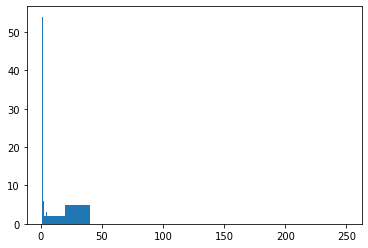

In [45]:
plt.hist(list((Counter(clusters.values()).values())),bins=[1,2,3,4,5,10,20,40,60,100,250])

In [55]:
for cid in range(10): 
    print("cluster ",cid,"---",end=" ")
    clusters, figure = display_clusters(dev_instances,dev_gold,cid)
    print(len(set(clusters.values()))," clusters found")
    display(figure)

cluster  0 --- X for self-loop, x for isolated turn, S for server
nb de tours= 249
38  clusters found


cluster  1 --- X for self-loop, x for isolated turn, S for server
nb de tours= 250
74  clusters found


cluster  2 --- X for self-loop, x for isolated turn, S for server
nb de tours= 250
45  clusters found


cluster  3 --- X for self-loop, x for isolated turn, S for server
nb de tours= 249
47  clusters found


cluster  4 --- X for self-loop, x for isolated turn, S for server
nb de tours= 250
66  clusters found


cluster  5 --- X for self-loop, x for isolated turn, S for server
nb de tours= 250
58  clusters found


cluster  6 --- X for self-loop, x for isolated turn, S for server
nb de tours= 250
48  clusters found


cluster  7 --- X for self-loop, x for isolated turn, S for server
nb de tours= 249
41  clusters found


cluster  8 --- X for self-loop, x for isolated turn, S for server
nb de tours= 250
36  clusters found


cluster  9 --- X for self-loop, x for isolated turn, S for server
nb de tours= 250
44  clusters found


(array([37.,  2.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1. ,  7.7, 14.4, 21.1, 27.8, 34.5, 41.2, 47.9, 54.6, 61.3, 68. ]),
 <BarContainer object of 10 artists>)

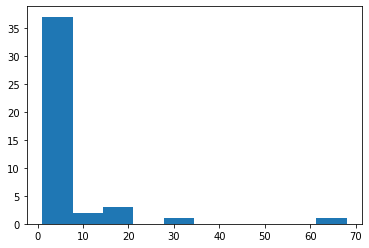

In [47]:
plt.hist(list((Counter(clusters.values()).values())))

In [48]:
display_chat(dev_instances,dev_gold,3)

0 -> NONE [<, joaopinto, >, internat1, ,, stat, file]
1 -> SELF-LOOP [<, ultratek, >, how, do, i, get, that, kool, icon, palette, at, the, botttom, of, my, screen, like, other, peeps, have]
2 -> [1] [<, allsystemsarego, >, ultratek, ,, AWN]
3 -> NONE [<, ActionParsnip1, >, ultratek, :, there, s, avant, -, window, -, navigator, kooldock, kiba, -, dock]
4 -> [3] [<, ActionParsnip1, >, ultratek, :, try, a, few, ,, see, which, you, like]
5 -> SELF-LOOP [*, Kondensuotas_pie, sweiki, kales]
6 -> [4] [<, ActionParsnip1, >, i, like, kooldock, if, i, HAD, to, have, one]
7 -> SELF-LOOP [<, Tex, -, Twil, >, Hello, ,, I, used, once, a, network, monitor, that, shows, via, a, web, gui, a, lot, of, information, about, the, network, traffic, per, host, (, bandwidth, ,, protocols, ,, data, transmitted, .., ), ., I, forgot, the, name, of, this, app, ,, anyone, ?]
8 -> [0] [<, internat1, >, joaopinto, :, i, m, told, that, wo, nt, work, for, what, i, want, .., ie, say, i, have, a, mnt, point, /home, /, sh

In [49]:
clusters, figure = display_clusters(train_instances,train_gold,10)
figure

X for self-loop, x for isolated turn, S for server


In [50]:
print(len(set(clusters.values()))," clusters found")

170  clusters found


In [51]:
len(clusters)

500

In [52]:
type(dev_instances[0]["lines"][0].tokens[1])

allennlp.data.tokenizers.token.Token

In [56]:
for cid in range(100): 
    print("cluster ",cid,"---",end=" ")
    clusters, figure = display_clusters(train_instances,train_gold,cid)
    print(len(set(clusters.values()))," clusters found")
    display(figure)

cluster  0 --- X for self-loop, x for isolated turn, S for server
nb de tours= 498
142  clusters found


cluster  1 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
75  clusters found


cluster  2 --- X for self-loop, x for isolated turn, S for server
nb de tours= 499
42  clusters found


cluster  3 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
112  clusters found


cluster  4 --- X for self-loop, x for isolated turn, S for server
nb de tours= 137
31  clusters found


cluster  5 --- X for self-loop, x for isolated turn, S for server
nb de tours= 191
63  clusters found


cluster  6 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
138  clusters found


cluster  7 --- X for self-loop, x for isolated turn, S for server
nb de tours= 350
40  clusters found


cluster  8 --- X for self-loop, x for isolated turn, S for server
nb de tours= 411
82  clusters found


cluster  9 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
180  clusters found


cluster  10 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
170  clusters found


cluster  11 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
207  clusters found


cluster  12 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
79  clusters found


cluster  13 --- X for self-loop, x for isolated turn, S for server
nb de tours= 909
355  clusters found


cluster  14 --- X for self-loop, x for isolated turn, S for server
nb de tours= 126
23  clusters found


cluster  15 --- X for self-loop, x for isolated turn, S for server
nb de tours= 99
15  clusters found


cluster  16 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
215  clusters found


cluster  17 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
78  clusters found


cluster  18 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
140  clusters found


cluster  19 --- X for self-loop, x for isolated turn, S for server
nb de tours= 283
105  clusters found


cluster  20 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
88  clusters found


cluster  21 --- X for self-loop, x for isolated turn, S for server
nb de tours= 499
244  clusters found


cluster  22 --- X for self-loop, x for isolated turn, S for server
nb de tours= 499
127  clusters found


cluster  23 --- X for self-loop, x for isolated turn, S for server
nb de tours= 98
22  clusters found


cluster  24 --- X for self-loop, x for isolated turn, S for server
nb de tours= 499
173  clusters found


cluster  25 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
102  clusters found


cluster  26 --- X for self-loop, x for isolated turn, S for server
nb de tours= 315
51  clusters found


cluster  27 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
75  clusters found


cluster  28 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
54  clusters found


cluster  29 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
98  clusters found


cluster  30 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
109  clusters found


cluster  31 --- X for self-loop, x for isolated turn, S for server
nb de tours= 650
89  clusters found


cluster  32 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
121  clusters found


cluster  33 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
227  clusters found


cluster  34 --- X for self-loop, x for isolated turn, S for server
nb de tours= 1165
374  clusters found


cluster  35 --- X for self-loop, x for isolated turn, S for server
nb de tours= 100
15  clusters found


cluster  36 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
96  clusters found


cluster  37 --- X for self-loop, x for isolated turn, S for server
nb de tours= 436
58  clusters found


cluster  38 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
96  clusters found


cluster  39 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
70  clusters found


cluster  40 --- X for self-loop, x for isolated turn, S for server
nb de tours= 498
265  clusters found


cluster  41 --- X for self-loop, x for isolated turn, S for server
nb de tours= 673
196  clusters found


cluster  42 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
169  clusters found


cluster  43 --- X for self-loop, x for isolated turn, S for server
nb de tours= 99
18  clusters found


cluster  44 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
99  clusters found


cluster  45 --- X for self-loop, x for isolated turn, S for server
nb de tours= 377
56  clusters found


cluster  46 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
158  clusters found


cluster  47 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
76  clusters found


cluster  48 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
54  clusters found


cluster  49 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
171  clusters found


cluster  50 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
134  clusters found


cluster  51 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
120  clusters found


cluster  52 --- X for self-loop, x for isolated turn, S for server
nb de tours= 140
17  clusters found


cluster  53 --- X for self-loop, x for isolated turn, S for server
nb de tours= 499
155  clusters found


cluster  54 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
141  clusters found


cluster  55 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
146  clusters found


cluster  56 --- X for self-loop, x for isolated turn, S for server
nb de tours= 291
31  clusters found


cluster  57 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
81  clusters found


cluster  58 --- X for self-loop, x for isolated turn, S for server
nb de tours= 800
310  clusters found


cluster  59 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
88  clusters found


cluster  60 --- X for self-loop, x for isolated turn, S for server
nb de tours= 331
116  clusters found


cluster  61 --- X for self-loop, x for isolated turn, S for server
nb de tours= 281
31  clusters found


cluster  62 --- X for self-loop, x for isolated turn, S for server
nb de tours= 100
32  clusters found


cluster  63 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
35  clusters found


cluster  64 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
132  clusters found


cluster  65 --- X for self-loop, x for isolated turn, S for server
nb de tours= 708
276  clusters found


cluster  66 --- X for self-loop, x for isolated turn, S for server
nb de tours= 191
17  clusters found


cluster  67 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
217  clusters found


cluster  68 --- X for self-loop, x for isolated turn, S for server
nb de tours= 307
46  clusters found


cluster  69 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
194  clusters found


cluster  70 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
259  clusters found


cluster  71 --- X for self-loop, x for isolated turn, S for server
nb de tours= 740
159  clusters found


cluster  72 --- X for self-loop, x for isolated turn, S for server
nb de tours= 365
53  clusters found


cluster  73 --- X for self-loop, x for isolated turn, S for server
nb de tours= 147
20  clusters found


cluster  74 --- X for self-loop, x for isolated turn, S for server
nb de tours= 84
24  clusters found


cluster  75 --- X for self-loop, x for isolated turn, S for server
nb de tours= 498
100  clusters found


cluster  76 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
112  clusters found


cluster  77 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
77  clusters found


cluster  78 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
94  clusters found


cluster  79 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
82  clusters found


cluster  80 --- X for self-loop, x for isolated turn, S for server
nb de tours= 210
27  clusters found


cluster  81 --- X for self-loop, x for isolated turn, S for server
nb de tours= 499
114  clusters found


cluster  82 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
113  clusters found


cluster  83 --- X for self-loop, x for isolated turn, S for server
nb de tours= 246
86  clusters found


cluster  84 --- X for self-loop, x for isolated turn, S for server
nb de tours= 978
123  clusters found


cluster  85 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
117  clusters found


cluster  86 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
92  clusters found


cluster  87 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
85  clusters found


cluster  88 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
145  clusters found


cluster  89 --- X for self-loop, x for isolated turn, S for server
nb de tours= 279
52  clusters found


cluster  90 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
192  clusters found


cluster  91 --- X for self-loop, x for isolated turn, S for server
nb de tours= 499
87  clusters found


cluster  92 --- X for self-loop, x for isolated turn, S for server
nb de tours= 100
7  clusters found


cluster  93 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
192  clusters found


cluster  94 --- X for self-loop, x for isolated turn, S for server
nb de tours= 100
27  clusters found


cluster  95 --- X for self-loop, x for isolated turn, S for server
nb de tours= 759
327  clusters found


cluster  96 --- X for self-loop, x for isolated turn, S for server
nb de tours= 499
230  clusters found


cluster  97 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
149  clusters found


cluster  98 --- X for self-loop, x for isolated turn, S for server
nb de tours= 498
155  clusters found


cluster  99 --- X for self-loop, x for isolated turn, S for server
nb de tours= 500
102  clusters found
